In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
import random
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
plt.rcParams.update({'font.size': 14})

In [5]:
%matplotlib notebook

This notebook applies quality metrics from Siegle, Jia, et al. biorxiv paper:
<br>https://www.biorxiv.org/content/10.1101/805010v1.full
<br>Especially, see the methods section 8.5 Spike sorting quality control. Additional useful info here:
<br>https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html
<br>https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

### Functions

In [6]:
## from https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html
def plot_metric(data, bins, x_axis_label, color, linestyle='solid', max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)

    x = b[:-1]
    y = gaussian_filter1d(h, 1)

    plt.plot(x, y, color=color, linestyle=linestyle)
    plt.xlabel(x_axis_label)
    plt.gca().get_yaxis().set_visible(False)
    [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    if max_value < np.max(y) * 1.1:
        max_value = np.max(y) * 1.1
    plt.ylim([0, max_value])
    
    return max_value

In [7]:
# select units based on quality metrics **REWRITE!!!!
def get_QC_units(metrics_df, isi_viol_thresh=0.5, amp_cutoff_thresh=0.1, pres_ratio_thresh=0.9):
    '''
    returns list of cluster IDs and metrics dataframe for clusters that pass QC
    quality metrics used here are same as those used by AllenSDK:
        ISI violations (default < 0.5)
        amplitude cutoff (default < 0.1)
        presence ratio (default > 0.9)
    '''
    selected_metrics = metrics_df[(
        (metrics_df['isi_viol'] < isi_viol_thresh) &
        (metrics_df['amplitude_cutoff'] < amp_cutoff_thresh) &
        (metrics_df['presence_ratio'] > pres_ratio_thresh)
    )]
    
    QC_clusters = selected_metrics.cluster_id.values

    return QC_clusters, selected_metrics

### Analyze both auto- and manual-sort at the same time:

In [8]:
data_sort = {
    'manual': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
    'auto': r'F:\EEG_exp\mouse543396\estim_vis1_autosort\experiment1\recording1',
}

In [9]:
compare_probes = ['probeB', 'probeC'] # ['probeB', 'probeC']

Load experiment

In [10]:
data_exp = {}
for sort_manner, recdiri in data_sort.items():
    data_exp[sort_manner] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


Loop through experiments and probes to make unit metrics dataframes

In [11]:
unit_metrics = {}
for probe in compare_probes:
    unit_metrics[probe] = {}
    for sort_manner, expi in data_exp.items():
        print(probe + ' ' + sort_manner)
        ## Load cluster_group and metrics
        cluster_group = pd.read_csv(expi.ephys_params[probe]['cluster_group'], sep='\t')
        cluster_metrics = pd.read_csv(expi.ephys_params[probe]['cluster_metrics'])
        spike_clusters = np.load(expi.ephys_params[probe]['spike_clusters'])
        
        ## Check cluster IDs
        if np.array_equal(cluster_group['cluster_id'].values.astype('int'), np.unique(spike_clusters)):
            print('IDs from cluster_group.tsv match spike_clusters.npy')
        else:
            print('IDs from cluster_group.tsv DO NOT match spike_clusters.npy. This may mean there are unsorted units, check in phy.')
            pass
            
        ## Merge cluster_group and metrics, if IDs match
        if np.array_equal(cluster_group['cluster_id'].values.astype('int'), cluster_metrics['cluster_id'].values.astype('int')):
            unit_metrics[probe][sort_manner] = pd.merge(cluster_group.rename(columns={'group':'label'}), cluster_metrics.drop(cluster_metrics.columns[0], axis=1), on='cluster_id') 
        else:
            print('IDs from cluster_group DO NOT match cluster_metrics. Need to re-run quality metrics?')
            continue
            
        ## Print cluster numbers
        print('Total clusters: %d' % (len(unit_metrics[probe][sort_manner])))
        print(unit_metrics[probe][sort_manner]['label'].value_counts())

probeB manual
IDs from cluster_group.tsv match spike_clusters.npy
Total clusters: 497
good     217
mua      178
noise    102
Name: label, dtype: int64
probeB auto
IDs from cluster_group.tsv match spike_clusters.npy
Total clusters: 524
good     396
noise    128
Name: label, dtype: int64
probeC manual
IDs from cluster_group.tsv match spike_clusters.npy
Total clusters: 362
mua      160
noise    114
good      88
Name: label, dtype: int64
probeC auto
IDs from cluster_group.tsv match spike_clusters.npy
Total clusters: 359
good     242
noise    117
Name: label, dtype: int64


Now loop through the metrics for each dataset and get units that pass QC metrics.

In [20]:
isi_viol_th = 0.5 # default from AllenSDK is < 0.5
amp_cutoff_th = 0.1 # default from AllenSDK is < 0.1
pres_ratio_th = 0.5 # default from AllenSDK is > 0.9

select_group = 'both' # 'good', 'mua', 'both', or 'all'

all_QC_metrics = {}
all_QC_clusters = {}
for probe, data_dict in unit_metrics.items():
    all_QC_metrics[probe] = {}
    all_QC_clusters[probe] = {}
    for sort_manner, dfmetrics in data_dict.items():
        print(probe + ' ' + sort_manner)
        ## Select units based on labels (AllenSDK only has good and noise, selects good)
        if select_group == 'good':
            select_units = dfmetrics[dfmetrics['label'] == 'good']
        elif select_group == 'mua':
            select_units = dfmetrics[dfmetrics['label'] == 'mua']
        elif select_group == 'both':
            select_units = dfmetrics[dfmetrics['label'] != 'noise']
        elif select_group == 'all':
            select_units = dfmetrics.copy()
            
        all_QC_clusters[probe][sort_manner], all_QC_metrics[probe][sort_manner] = get_QC_units(
            select_units,
            isi_viol_thresh=isi_viol_th,
            amp_cutoff_thresh=amp_cutoff_th,
            pres_ratio_thresh=pres_ratio_th
        )
        print(len(all_QC_clusters[probe][sort_manner]))

probeB manual
173
probeB auto
156
probeC manual
101
probeC auto
95


#### Plot metrics for different datasets

In [13]:
color_dict = {'probeB' : 'b',
              'probeC' : 'm'}
ls_dict = {'manual' : 'solid',
           'auto' : 'dashed'}

ISI violations

<IPython.core.display.Javascript object>


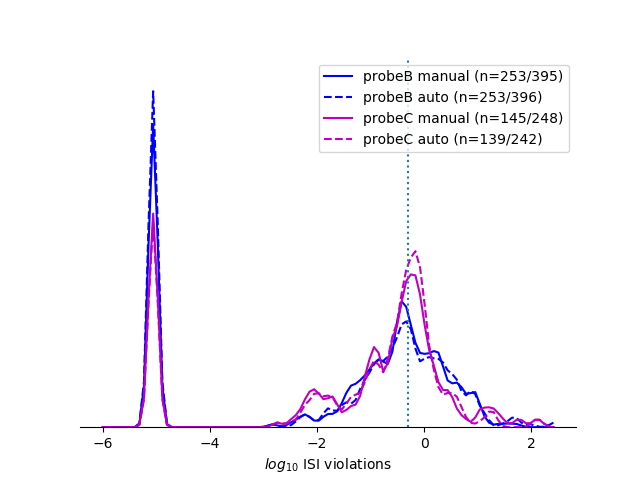

In [14]:
bins = np.linspace(-6,2.5,100)
max_value = -np.inf

labels = []
for probe, data_dict in unit_metrics.items():
    for sort_manner, dfmetrics in data_dict.items():
        ## Select units based on labels (AllenSDK only has good and noise, selects good)
        if select_group == 'good':
            select_units = dfmetrics[dfmetrics['label'] == 'good']
        elif select_group == 'mua':
            select_units = dfmetrics[dfmetrics['label'] == 'mua']
        elif select_group == 'both':
            select_units = dfmetrics[dfmetrics['label'] != 'noise']
        elif select_group == 'all':
            select_units = dfmetrics.copy()
            
        data = np.log10(select_units['isi_viol'] + 1e-5) 
    
        max_value = plot_metric(data, bins, '$log_{10}$ ISI violations', color_dict[probe], ls_dict[sort_manner], max_value)
        labels.append('%s %s (n=%d/%d)' % (probe, sort_manner, np.sum(select_units.isi_viol < isi_viol_th), len(select_units)))

_ = plt.legend(labels)
plt.plot([np.log10(0.5), np.log10(0.5)],[0,max_value], ':')

Amplitude cutoff

<IPython.core.display.Javascript object>


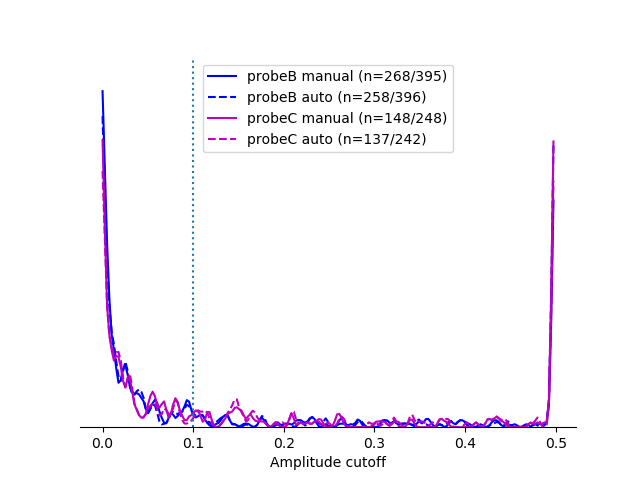

In [15]:
bins = np.linspace(0,0.5,200)
max_value = -np.inf

labels = []
for probe, data_dict in unit_metrics.items():
    for sort_manner, dfmetrics in data_dict.items():
        ## Select units based on labels (AllenSDK only has good and noise, selects good)
        if select_group == 'good':
            select_units = dfmetrics[dfmetrics['label'] == 'good']
        elif select_group == 'mua':
            select_units = dfmetrics[dfmetrics['label'] == 'mua']
        elif select_group == 'both':
            select_units = dfmetrics[dfmetrics['label'] != 'noise']
        elif select_group == 'all':
            select_units = dfmetrics.copy()
            
        data = select_units['amplitude_cutoff']
    
        max_value = plot_metric(data, bins, 'Amplitude cutoff', color_dict[probe], ls_dict[sort_manner], max_value)
        labels.append('%s %s (n=%d/%d)' % (probe, sort_manner, np.sum(select_units.amplitude_cutoff < amp_cutoff_th), len(select_units)))
        
_ = plt.legend(labels)
plt.plot([0.1, 0.1],[0,max_value], ':')

Presence ratio

<IPython.core.display.Javascript object>


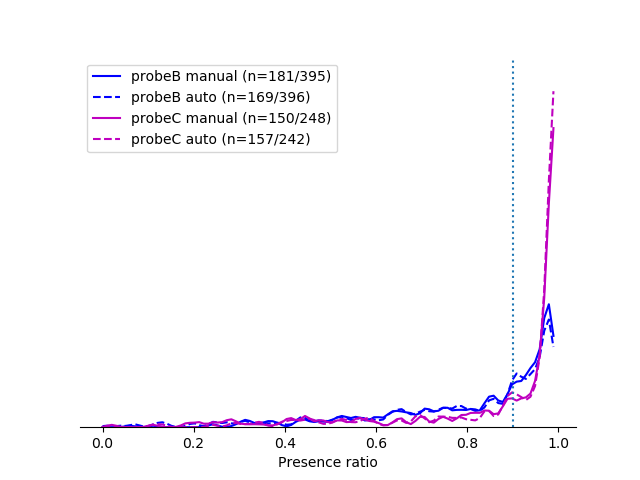

In [16]:
bins = np.linspace(0,1,100)
max_value = -np.inf

labels = []
for probe, data_dict in unit_metrics.items():
    for sort_manner, dfmetrics in data_dict.items():
        ## Select units based on labels (AllenSDK only has good and noise, selects good)
        if select_group == 'good':
            select_units = dfmetrics[dfmetrics['label'] == 'good']
        elif select_group == 'mua':
            select_units = dfmetrics[dfmetrics['label'] == 'mua']
        elif select_group == 'both':
            select_units = dfmetrics[dfmetrics['label'] != 'noise']
        elif select_group == 'all':
            select_units = dfmetrics.copy()
            
        data = select_units['presence_ratio']
    
        max_value = plot_metric(data, bins, 'Presence ratio', color_dict[probe], ls_dict[sort_manner], max_value)
        labels.append('%s %s (n=%d/%d)' % (probe, sort_manner, np.sum(select_units.presence_ratio > pres_ratio_th), len(select_units)))
        
_ = plt.legend(labels)
plt.plot([0.9, 0.9],[0,max_value], ':')

## Plot single data set

### Data set that has been manually sorted after the auto sort

#### Load EEGexp object

In [8]:
rec_folder = r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1' # points to folder containing stim_table.csv
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [9]:
choose_probe = 'probeC'

#### Load data

In [10]:
cluster_group = pd.read_csv(exp.ephys_params[choose_probe]['cluster_group'], sep='\t')
cluster_metrics = pd.read_csv(exp.ephys_params[choose_probe]['cluster_metrics'])
spike_clusters = np.load(exp.ephys_params[choose_probe]['spike_clusters'])

In [11]:
cluster_ids = cluster_group['cluster_id'].values.astype('int')
print(len(cluster_ids))

362


In [12]:
## check if cluster ids match across the files
if np.array_equal(cluster_ids, np.unique(spike_clusters)):
    print('IDs from cluster_group.tsv match spike_clusters.npy')
else:
    print('IDs from cluster_group.tsv DO NOT match spike_clusters.npy. This may mean there are unsorted units, check in phy.')

IDs from cluster_group.tsv match spike_clusters.npy


In [13]:
if np.array_equal(cluster_ids, cluster_metrics['cluster_id'].values.astype('int')):
    units = pd.merge(cluster_group.rename(columns={'group':'label'}), cluster_metrics.drop(cluster_metrics.columns[0], axis=1), on='cluster_id') 
else:
    print('IDs from cluster_group DO NOT match cluster_metrics. Need to re-run quality metrics?')

In [14]:
units.head()

,cluster_id,label,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,silhouette_score,max_drift,cumulative_drift,epoch_name_quality_metrics,epoch_name_waveform_metrics,peak_channel,snr,duration,halfwidth,PT_ratio,repolarization_slope,recovery_slope,amplitude,spread,velocity_above,velocity_below
0,2,mua,2.171777,0.61,0.123893,0.028060,35.827002,0.532487,4.304662,0.869565,0.001808,0.086483,36.95,36.95,complete_session,complete_session,2,2.660752,0.233501,0.123618,0.535656,0.434890,-0.122929,104.993655,50.0,6.936348,NaN
1,3,good,0.006548,0.12,0.000000,0.500000,NaN,NaN,4.717724,NaN,0.000000,NaN,NaN,NaN,complete_session,complete_session,0,3.287361,0.260972,0.137353,0.641447,0.662055,-0.179954,68.955714,80.0,2.305575,NaN
2,4,good,2.364477,0.92,0.083618,0.138746,56.504307,0.043160,5.300526,0.911647,0.003413,0.043150,33.17,33.17,complete_session,complete_session,0,3.119249,0.247236,0.137353,0.773036,0.595969,-0.162799,53.479140,30.0,0.000000,NaN
3,5,mua,5.524078,0.98,0.517038,0.429071,50.497876,0.121224,5.616685,0.961333,0.000281,0.092113,18.68,18.68,complete_session,complete_session,1,2.874734,0.412060,0.178559,0.353215,0.389969,-0.065850,102.704355,40.0,0.480737,NaN
4,7,noise,3.973120,0.92,4.502822,0.500000,NaN,NaN,NaN,NaN,NaN,0.047541,80.01,80.01,complete_session,complete_session,116,0.364090,1.098827,0.741709,0.977105,0.026855,NaN,49.600785,170.0,-0.114461,1.94584


In [15]:
print('Total clusters on %s: %d' % (choose_probe, len(units)))
print('good: %d, mua: %d, noise: %d' % (units['label'].value_counts().good, units['label'].value_counts().mua, units['label'].value_counts().noise))


Total clusters on probeC: 362
good: 88, mua: 160, noise: 114


### Select units for following analysis

In [16]:
## choose units (either 'good', 'mua', 'both', or 'all')
select_group = 'both' # 'good', 'mua', 'both', or 'all'

if select_group == 'good':
    select_units = units[units['label'] == 'good']
elif select_group == 'mua':
    select_units = units[units['label'] == 'mua']
elif select_group == 'both':
    select_units = units[units['label'] != 'noise']
elif select_group == 'all':
    select_units = units.copy()

<IPython.core.display.Javascript object>


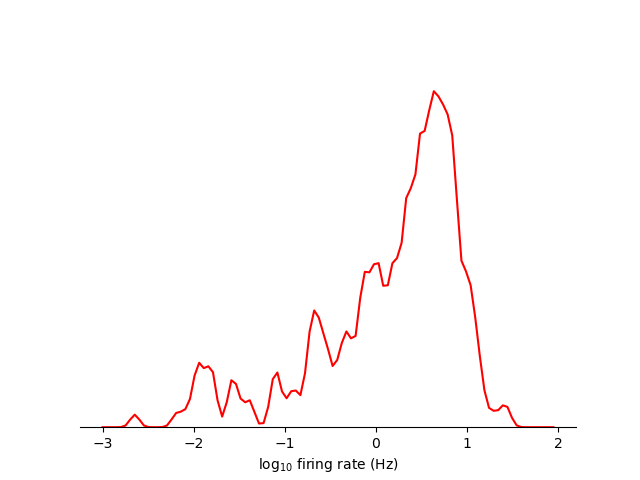

In [20]:
## Plot distribution of firing rates across all units
data = np.log10(select_units['firing_rate'])
bins = np.linspace(-3,2,100)

max_value = plot_metric(data, bins, 'log$_{10}$ firing rate (Hz)', 'red', 'solid')

The three main quality metrics used by AllenSDK are isi_violations (< 0.5), amplitude_cutoff (< 0.1), and presence_ratio (> 0.9).

<IPython.core.display.Javascript object>


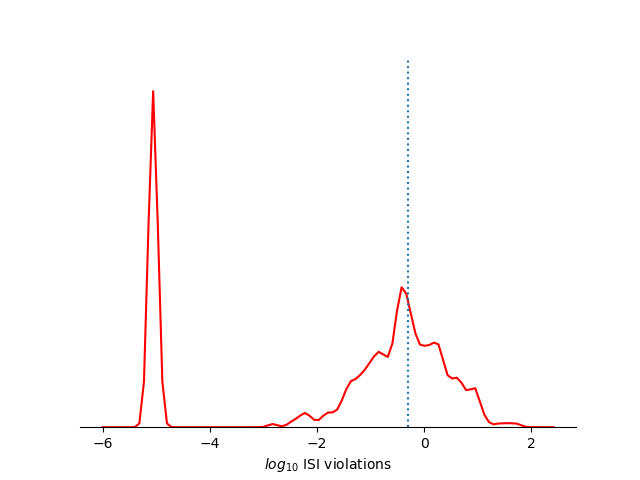

In [57]:
## Plot ISI violations across all units - log scale
data = np.log10(select_units['isi_viol'] + 1e-5)
bins = np.linspace(-6,2.5,100)
max_value = -np.inf

max_value = plot_metric(data, bins, '$log_{10}$ ISI violations', 'red')
plt.plot([np.log10(0.5), np.log10(0.5)],[0,max_value], ':')

## This metric reports the relative firing rate of the hypothetical neurons that are generating these violations. You can
## interpret an ISI violations value of 0.5 as meaning that contamining spikes are occurring at roughly half the rate of
## "true" spikes for that unit. The default threshold of 0.5 is still quite permissive.

<IPython.core.display.Javascript object>


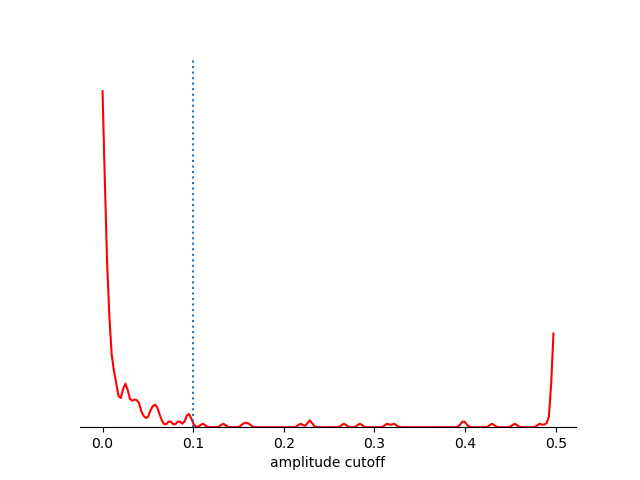

In [53]:
## Plot distribution of amplitude_cutoff across all units
data = select_units['amplitude_cutoff']
bins = np.linspace(0,0.5,200)
max_value = -np.inf

max_value = plot_metric(data, bins, 'amplitude cutoff', 'red')
plt.plot([0.1, 0.1],[0,max_value], ':')

## Aamplitude cutoff provides an estimate of the false negative rate—e.g., the fraction of spikes below the spike detection
## threshold. Thus, amplitude cutoff is a measure of unit "completeness" that is complementary to presence ratio.

<IPython.core.display.Javascript object>


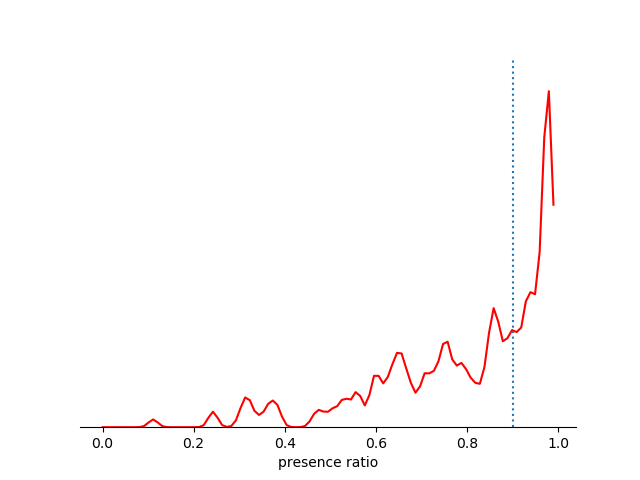

In [54]:
## Plot distribution of presence_ratio across all units
data = select_units['presence_ratio']
bins = np.linspace(0,1,100)
max_value = -np.inf

max_value = plot_metric(data, bins, 'presence ratio', 'red')
plt.plot([0.9, 0.9],[0,max_value], ':')
## It measures the fraction of time during a session in which a unit is spiking, and ranges from 0 to 0.99. Perhaps this
## makes more sense to calculate only over the awake period?

## Data set that has been only auto sorted

#### Load EEGexp object

In [5]:
rec_folder2 = r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1' # points to folder containing stim_table.csv
exp2 = EEGexp(rec_folder2, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [13]:
choose_probe = 'probeB'

#### Load data

In [14]:
cluster_group = pd.read_csv(exp.ephys_params[choose_probe]['cluster_group'], sep='\t')
cluster_metrics = pd.read_csv(exp.ephys_params[choose_probe]['cluster_metrics'])
spike_clusters = np.load(exp.ephys_params[choose_probe]['spike_clusters'])

In [15]:
cluster_ids = cluster_group['cluster_id'].values.astype('int')
# print(len(cluster_ids))

362


In [16]:
## check if cluster ids match across the files
if np.array_equal(cluster_ids, np.unique(spike_clusters)):
    print('IDs from cluster_group.tsv match spike_clusters.npy')
else:
    print('IDs from cluster_group.tsv DO NOT match spike_clusters.npy. This may mean there are unsorted units, check in phy.')

IDs from cluster_group.tsv match spike_clusters.npy


#### Load some spike files to see why ecephys_spike_sorting/modules/quality_metrics is failing on 543396 probeC

i think it has something to do with the spike clusters...

In [7]:
spike_clusters = np.load(exp.ephys_params[choose_probe]['spike_clusters'])

In [8]:
np.unique(spike_clusters)

array([  2,   3,   4,   5,   7,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  20,  22,  24,  25,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  38,  39,  40,  41,  42,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 141, 142, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 166, 167, 168, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

In [7]:
# make paths
stim_log_path = exp.stimulus_log_file
probe_info = exp.ephys_params[mask_probe]['probe_info']
ap_time_path = exp.ephys_params[mask_probe]['ap_timestamps']
# spike_times
spike_times_path = exp.ephys_params[mask_probe]['spike_times']
spike_clusters_path = exp.ephys_params[mask_probe]['spike_clusters']

# paths for artifact (this code creates these files at the end, not necessary to have them, but should specify where you want them saved)
arttimes_path = os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'artifact_onset_master_clock.npy')
maskdur_path = os.path.join(exp.experiment_folder, (mask_probe + '_sorted'), 'mask_sampleduration.npy')